# Summary

Double-checking that interpreting the output of a cross-entropy-trained network makes sense as a probability. This is a demonstration that the probabilities are computed correctly. 


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=ImportWarning)
import h5py
#warnings.resetwarnings()
import keras
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Setting up the Data

A large dataset sampled from two Gaussians. One is centered at 0 and one is centered at 1.
Let's look at a distribution of the 0 and 1 categories.


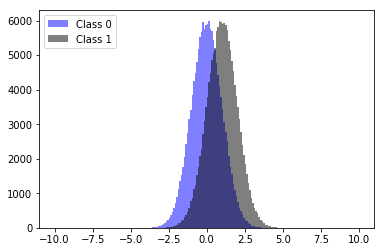

In [2]:
nsamples = 300000

X_train = np.zeros(shape=(nsamples,1))
y_train = np.zeros(shape=(nsamples))

X_train[0:nsamples//2,:] = np.random.randn(nsamples//2,1)
y_train[0:nsamples//2] = 0 
X_train[nsamples//2:nsamples,:] = np.random.randn(nsamples//2,1) + 1.0
y_train[nsamples//2:nsamples] = 1 

_ = plt.hist(X_train[0:nsamples//2,:],bins=200,range=(-10,10),label="Class 0",alpha=0.5,color='blue')
_ = plt.hist(X_train[nsamples//2:nsamples,:],bins=200,range=(-10,10),label="Class 1",alpha=0.5,color='black')
plt.legend(loc='upper left')

# The model

This is an over-complicated model. The reason for the complexity is that I am looking at the detailed probabilities that come out, not just the 0/1 classification and I want to make sure that I have a model that's nuanced enough to capture the details.

Note in fitting the model, the data is not randomly sampled. The first half is the 0s and the second half is the 1s. I'm not batch training, though, so it's fine. 

In [3]:
X_input = keras.layers.Input((1,))
layer1 = keras.layers.Dense(20, activation='relu')
X = layer1(X_input)
layer2 = keras.layers.Dense(20, activation='relu')
X = layer2(X_input)
layer3 = keras.layers.Dense(20, activation='relu')
X = layer3(X_input)
layer4 = keras.layers.Dense(1, activation='sigmoid')
X = layer4(X)

adam = keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model = keras.models.Model(inputs = X_input, outputs = X, name='model')
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [4]:
model.fit(x=X_train,y=y_train,batch_size=nsamples,epochs=50,verbose=0)


# Ideal NN output

The NN should compute the probability that a given example is of class 0 or 1. But for this dataset, I know those probabilities precisely; the two populations are just drawn from Gaussians of different. So here, we get the probabilities as a function of x from the NN and computed exactly. They agree well.

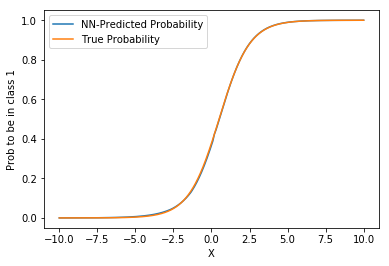

In [5]:
# probability vs x
X_test = np.linspace(-10,10,10000).reshape(10000,1)
pred = model.predict(X_test)

# I can compute the probability exactly and compare to the predicted
# prob from the model
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(X_test,pred,label="NN-Predicted Probability")
g1 = np.exp(-X_test*X_test/2.)
g2 = np.exp(-(X_test-1)*(X_test-1)/2.)
ax.plot(X_test,g2/(g1+g2),label="True Probability")
ax.set_xlabel("X")
ax.set_ylabel("Prob to be in class 1")
ax.legend(loc='upper left')
#plt.savefig("prob.png")

